In [1]:
# Kuntal Ghosh
# Mini tutorial on recurrent neural networks

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Generate a complex toy dataset
def generate_toy_data(n_points=1000):
    t = np.linspace(0, 9.5, n_points)
    energy = -100 + 5 * np.sin(t) + 2 * np.cos(3*t) + 0.5 * np.sin(5*t) + np.random.normal(0, 0.5, n_points)
    return t, energy

# Prepare data for the RNN
def prepare_data(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

In [3]:
# Define the RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.rnn = nn.Sequential(
            nn.RNN(input_size, hidden_size, num_layers, batch_first=True),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, output_size)
        )

    def forward(self, x):
        out, _ = self.rnn[0](x)
        return self.rnn[1:](out[:, -1, :])

In [4]:
# Generate data
t, energy = generate_toy_data(n_points=2000)

# Save original dataset to file
with open('original_data.txt', 'w') as f:
    f.write("Time\tEnergy\n")
    for ti, ei in zip(t, energy):
        f.write(f"{ti:.4f}\t{ei:.4f}\n")

# Normalize the data
scaler = MinMaxScaler()
energy_normalized = scaler.fit_transform(energy.reshape(-1, 1)).flatten()

In [5]:
# Prepare data for RNN
seq_length = 50
X, y = prepare_data(energy_normalized, seq_length)

# Split data into train and test sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [6]:
# Initialize model, loss function, and optimizer
model = RNN(input_size=1, hidden_size=100, num_layers=2, output_size=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Any other custom optimizers can be used (I'm just using Adam for demonstration purposes)

# Training loop with early stopping
n_epochs = 500
patience = 20
best_loss = float('inf')
counter = 0

for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X.unsqueeze(2))
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test.unsqueeze(2))
        val_loss = criterion(val_outputs.squeeze(), y_test)

    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1

    if counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}')

Epoch [10/500], Train Loss: 0.0017, Val Loss: 0.0019
Epoch [20/500], Train Loss: 0.0018, Val Loss: 0.0014
Epoch [30/500], Train Loss: 0.0015, Val Loss: 0.0014
Epoch [40/500], Train Loss: 0.0014, Val Loss: 0.0019
Epoch [50/500], Train Loss: 0.0014, Val Loss: 0.0013
Epoch [60/500], Train Loss: 0.0015, Val Loss: 0.0014
Epoch [70/500], Train Loss: 0.0016, Val Loss: 0.0013
Epoch [80/500], Train Loss: 0.0014, Val Loss: 0.0016
Epoch [90/500], Train Loss: 0.0014, Val Loss: 0.0012
Epoch [100/500], Train Loss: 0.0013, Val Loss: 0.0026
Early stopping at epoch 110


In [7]:
# Load best model
model.load_state_dict(torch.load('best_model.pth'))

# Make predictions
model.eval()
with torch.no_grad():
    test_predictions = model(X_test.unsqueeze(2)).squeeze().numpy()
    test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()

# Forecast future values
future_steps = 500
last_sequence = X_test[-1].unsqueeze(0)
forecasted_values = []

for _ in range(future_steps):
    with torch.no_grad():
        next_pred = model(last_sequence.unsqueeze(2)).item()
        forecasted_values.append(next_pred)
        last_sequence = torch.cat((last_sequence[:, 1:], torch.FloatTensor([[next_pred]])), dim=1)

forecasted_values = scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1)).flatten()

/tmp/ipykernel_19161/2124592922.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


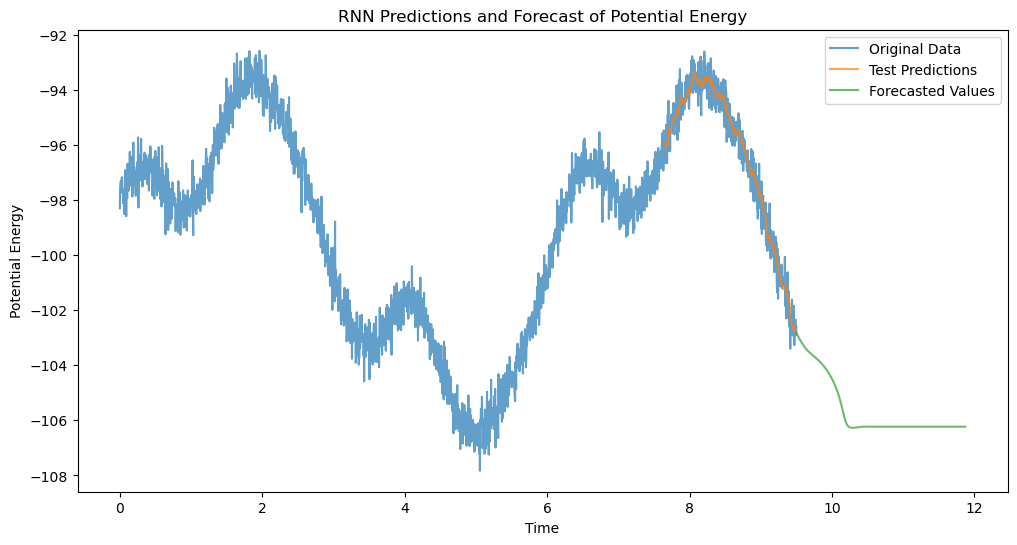

In [8]:
# Save predictions to file
with open('predictions.txt', 'w') as f:
    f.write("Time\tPredicted_Energy\n")
    # Write test predictions
    for i, pred in enumerate(test_predictions):
        f.write(f"{t[train_size+seq_length+i]:.4f}\t{pred:.4f}\n")
    # Write forecasted values
    for i, pred in enumerate(forecasted_values):
        f.write(f"{t[-1] + (i+1)*(t[1]-t[0]):.4f}\t{pred:.4f}\n")

# Plotting results
plt.figure(figsize=(12, 6))
plt.plot(t, energy, label='Original Data', alpha=0.7)
plt.plot(t[train_size+seq_length:], test_predictions, label='Test Predictions', alpha=0.7)
plt.plot(np.arange(t[-1], t[-1] + future_steps*(t[1]-t[0]), t[1]-t[0]), forecasted_values, label='Forecasted Values', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Potential Energy')
plt.legend()
plt.title('RNN Predictions and Forecast of Potential Energy')
plt.savefig('energy_prediction_plot.png')
plt.show()